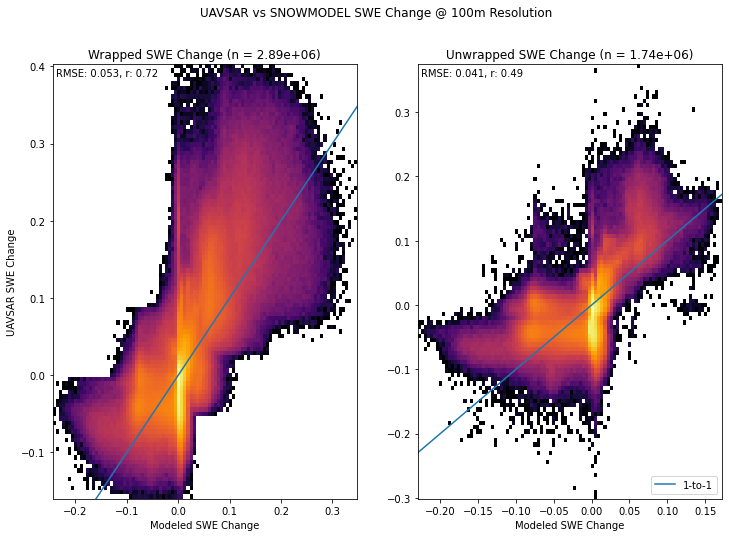

In [313]:
import xarray as xr
import numpy as np
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# loop through each flight pair and calculate rmse, r2, plot

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

fig, axes = plt.subplots(1, 2, figsize = (12, 8))


for i, var in enumerate(['int','unw']):
    xs = []
    ys = []
    var = f'uavsar_dSD_{var}'
    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        if var in ds.data_vars:
            ds = ds#.coarsen(x = 3, boundary = 'pad').mean().coarsen(y = 3, boundary = 'pad').mean()
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))

    # stack arrays
    xs = np.hstack(xs)
    ys = np.hstack(ys)

    xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys))]
    ys = ys[(~np.isnan(xs)) & (~np.isnan(ys)) ]
    xs = xs_tmp

    # range = [[-0.001, 0.002], [-0.1, 0.1]]
    axes[i].hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno) #, range = range)
    axes[i].set_xlabel('Modeled SWE Change')
    if i == 0:
        axes[i].set_title(f'Wrapped SWE Change (n = {len(ys):.2e})')
    else:
        axes[i].set_title(f'Unwrapped SWE Change (n = {len(ys):.2e})')
    #axes[i].set_xlim(range[0])
    #axes[i].set_ylim(range[1])

    from sklearn.metrics import mean_squared_error
    rms = mean_squared_error(xs, ys, squared=False)

    from scipy.stats import pearsonr
    r, p = pearsonr(xs, ys)
    axes[i].text(.01, .99, f'RMSE: {rms:.2}, r: {r:.2}', ha='left', va='top', transform=axes[i].transAxes)
plt.suptitle('UAVSAR vs SNOWMODEL SWE Change @ 100m Resolution')

axes[0].set_ylabel('UAVSAR SWE Change')
# identity line
for ax in axes:
    ax.plot([-1,1], [-1,1], label = '1-to-1')
axes[1].legend(loc = 'lower right')

plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/model/hist2d_all_100.png')

# subsetting

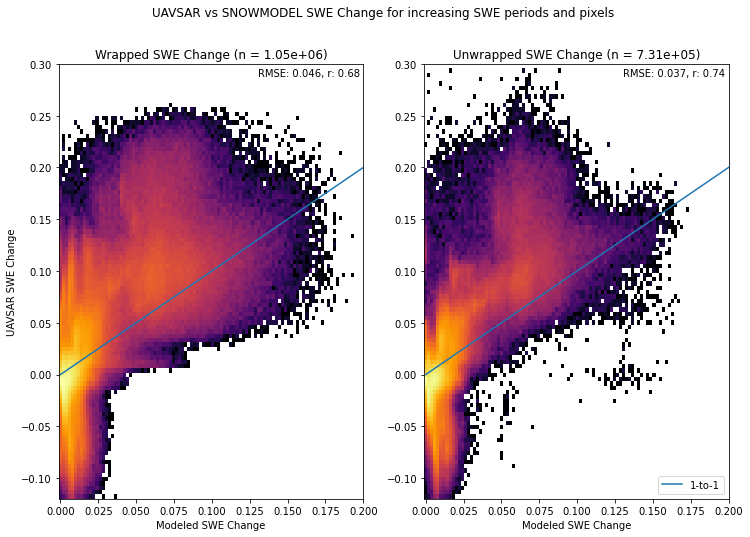

In [312]:
import xarray as xr
import numpy as np
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# loop through each flight pair and calculate rmse, r2, plot

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

fig, axes = plt.subplots(1, 2, figsize = (12, 8))


for i, var in enumerate(['int','unw']):
    xs = []
    ys = []
    var = f'uavsar_dSD_{var}'
    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        if ds.attrs['dSWE'] > 0 and 'uavsar_dSD_unw' in ds.data_vars:
            if var in ds.data_vars:
                ds = ds#.coarsen(x = 3, boundary = 'pad').mean().coarsen(y = 3, boundary = 'pad').mean()
                xs.append(ds['swe'].values.ravel())
                ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))

    # stack arrays
    xs = np.hstack(xs)
    ys = np.hstack(ys)

    xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys)) & (xs > 0)]
    ys = ys[(~np.isnan(xs)) & (~np.isnan(ys)) & (xs > 0)]
    xs = xs_tmp

    range = [[-0.001, 0.2], [-0.12, 0.3]]
    axes[i].hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno, range = range)
    axes[i].set_xlabel('Modeled SWE Change')
    if i == 0:
        axes[i].set_title(f'Wrapped SWE Change (n = {len(ys):.2e})')
    else:
        axes[i].set_title(f'Unwrapped SWE Change (n = {len(ys):.2e})')

    from sklearn.metrics import mean_squared_error
    rms = mean_squared_error(xs, ys, squared=False)

    from scipy.stats import pearsonr
    r, p = pearsonr(xs, ys)
    axes[i].text(.99, .99, f'RMSE: {rms:.2}, r: {r:.2}', ha='right', va='top', transform=axes[i].transAxes)
plt.suptitle('UAVSAR vs SNOWMODEL SWE Change for increasing SWE periods and pixels')

axes[0].set_ylabel('UAVSAR SWE Change')
# identity line
for ax in axes:
    ax.plot([0,1], [0,1], label = '1-to-1')
axes[1].legend(loc = 'lower right')
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/model/hist2d_increasing.png')

# example maps

/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/232_2021-02-03_2021-02-10.sd.model.nc


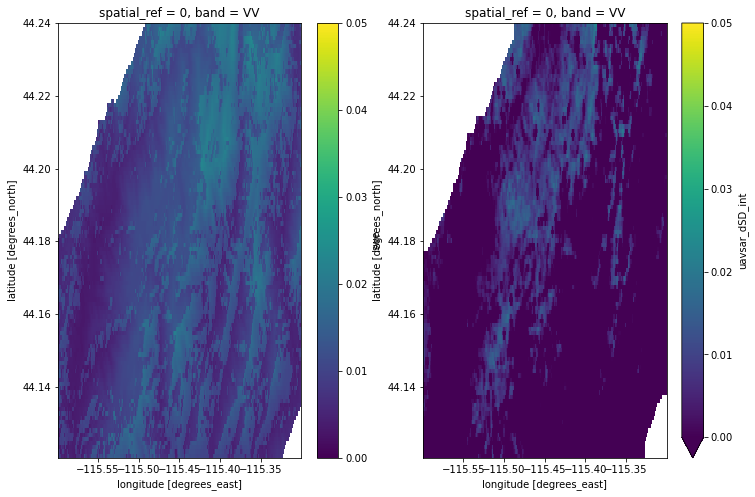

In [163]:
from scipy.ndimage import gaussian_filter
for fp in ncs_dir.glob('*.sd.model.nc'):
    if str(fp) == '/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/232_2021-02-03_2021-02-10.sd.model.nc':
        print(fp)
        ds = xr.open_dataset(fp)
        ds = ds.sel(y = slice(44.12, 44.24), x = slice(-115.6, -115.3))
        fig, axes = plt.subplots(1, 2, figsize = (12,8))
        ds['swe'].where(~ds['uavsar_dSD_int'].sel(band = 'VV').isnull()).plot(ax = axes[0], vmin = 0, vmax= 0.05)
        ds['uavsar_dSD_int'].loc[dict(band = 'VV')] = gaussian_filter(ds['uavsar_dSD_int'].sel(band = 'VV'), 0.7)
        (ds['uavsar_dSD_int'].sel(band = 'VV') * (ds.attrs['mean_density']/ 997)).plot(ax = axes[1], vmin = 0, vmax= 0.05)
        plt.show()

In [238]:
# mean through time!!!
n = len(list(ncs_dir.glob('*.sd.model.nc')))

for var in ['swe', 'uavsar_dSD_int']:
    for i, fp in enumerate(ncs_dir.glob('*.sd.model.nc')):
        ds = xr.open_dataset(fp)
        
        if i == 0:
            shape = np.array([(*ds.swe.shape, n)], dtype = object).ravel()
            full_array = np.zeros(shape)
            main_ds = ds
        else:
            ds = ds.rio.reproject_match(main_ds)

        if 'uavsar' not in var:   
            full_array[:, :, i-1] = ds[var].values
        else:
            full_array[:, :, i-1] = ds[var].sel(band = 'VV').values

    if 'uavsar' not in var:
        main_ds[var].data = np.mean(full_array, axis = 2)
    else:
        main_ds[var].loc[dict(band = 'VV')].data = np.mean(full_array, axis = 2)

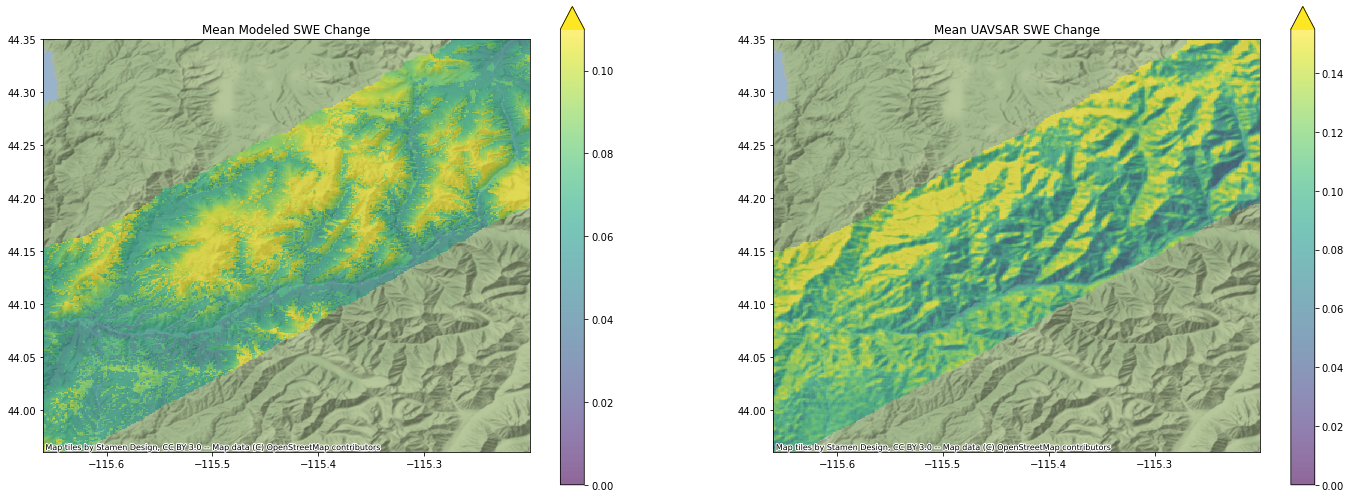

In [277]:
import contextily as ctx
ds = main_ds
ds = ds.sel(y = slice(43.96, 44.35), x = slice(-115.66, -115.2))
fig, axes = plt.subplots(1, 2, figsize = (24,16))
# ds['swe'].data = gaussian_filter(ds['swe'], 0.1)
ds['swe'].where(~ds['uavsar_dSD_int'].sel(band = 'VV').isnull()).plot(ax = axes[0], vmin = 0, vmax= 0.11, alpha = 0.6, cbar_kwargs = {'label': '', 'shrink': 0.55})
ds['uavsar_dSD_int'].loc[dict(band = 'VV')] = gaussian_filter(ds['uavsar_dSD_int'].sel(band = 'VV'), 0.7)
(ds['uavsar_dSD_int'].sel(band = 'VV') * (ds.attrs['mean_density']/ 997)).plot(ax = axes[1], vmin = 0.0, vmax = 0.155, alpha = 0.6, cbar_kwargs = {'label': '', 'shrink': 0.55})

axes[0].set_title('Mean Modeled SWE Change')
axes[1].set_title('Mean UAVSAR SWE Change')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ctx.add_basemap(ax = ax, crs = 'EPSG:4326', source = ctx.providers.Stamen.Terrain)

plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/model/mean_maps.png')